In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# HPI / RPI exploration

In [44]:
hpi_base = open("../data/hpi_base.pkl","rb")
hpi = pd.read_pickle(hpi_base)
hpi = pd.DataFrame(hpi)
hpi.head()

,period_start,period_end,trans_period,coef,price_index,census_zcta5_geoid,census_cbsa_geoid
0,2007-01-01,2007-01-31,1.0,0.000000,100.000000,00000,11460
1,2007-02-01,2007-02-28,2.0,-0.018513,98.165768,00000,11460
2,2007-03-01,2007-03-31,3.0,-0.016101,98.402746,00000,11460
3,2007-04-01,2007-04-30,4.0,-0.014683,98.542442,00000,11460
4,2007-05-01,2007-05-31,5.0,-0.049284,95.191042,00000,11460


In [13]:
hpi.shape
# 2 million observations

(2289507, 7)

In [3]:
len(hpi['census_cbsa_geoid'].unique()) # 91 markets
len(hpi['census_zcta5_geoid'].unique()) # 11189 zip codes
len(hpi['trans_period'].unique()) # 200 periods, monthly from 2007 to present

200

In [45]:
rpi_index = open("../data/rpi_index.pkl","rb")
rpi = pd.read_pickle(rpi_index)
rpi = pd.DataFrame(rpi)
rpi = rpi.rename({"date": "period_start"}, axis = 1)
rpi.head()

,period_start,rental_index,census_cbsa_geoid,census_zcta5_geoid
0,2010-02-01,100.000000,17140,00000
1,2010-03-01,74.931176,17140,00000
2,2010-04-01,79.105472,17140,00000
3,2010-05-01,70.164398,17140,00000
4,2010-06-01,54.594201,17140,00000


In [91]:
rpi.shape
# 1.6 million observations

(1684308, 4)

In [93]:
len(rpi['census_cbsa_geoid'].unique()) # 87 markets
len(rpi['census_zcta5_geoid'].unique()) # 11241 zip codes
len(rpi['period_start'].unique()) # 164 dates, monthly from 2010 to present

164

In [97]:
rpi['census_zcta5_geoid'].value_counts()

00000    11897
32162      346
21787      328
23117      328
22546      328
         ...  
34785       18
33521       18
33538       18
33513       18
33585       18
Name: census_zcta5_geoid, Length: 11241, dtype: int64

In [99]:
rpi[rpi['census_zcta5_geoid'] == '00000']

,period_start,rental_index,census_cbsa_geoid,census_zcta5_geoid
0,2010-02-01,100.000000,17140,00000
1,2010-03-01,74.931176,17140,00000
2,2010-04-01,79.105472,17140,00000
3,2010-05-01,70.164398,17140,00000
4,2010-06-01,54.594201,17140,00000
...,...,...,...,...
1675775,2023-04-01,173.400618,49180,00000
1675776,2023-05-01,174.693641,49180,00000
1675777,2023-06-01,175.552431,49180,00000
1675778,2023-07-01,175.585619,49180,00000


In [46]:
# remove market aggregate rows
rpi_clean = rpi[rpi['census_zcta5_geoid'] != '00000']
hpi_clean = hpi[hpi['census_zcta5_geoid'] != '00000']

In [83]:
sfr = pd.merge(rpi_clean, hpi_clean, how = 'left', on = ['period_start', 'census_zcta5_geoid'])
sfr = sfr.drop(['census_cbsa_geoid_x', 'period_end', 'census_cbsa_geoid_y'], axis=1)
sfr = sfr.rename({'rental_index': 'sf_rental_index', 
                  'price_index': 'sf_price_index', 
                  'census_zcta5_geoid': 'zipcode'}, axis=1)
sfr.head(10)

,period_start,sf_rental_index,zipcode,trans_period,coef,sf_price_index
0,2010-02-01,100.000000,47038,38.0,-0.228594,82.953446
1,2010-03-01,67.975154,47038,39.0,-0.195522,82.872184
2,2010-04-01,78.247524,47038,40.0,-0.185380,82.536945
3,2010-05-01,62.539852,47038,41.0,-0.177184,82.263764
4,2010-06-01,50.101684,47038,42.0,-0.182479,81.827389
5,2010-07-01,78.789211,47038,43.0,-0.204863,82.240525
6,2010-08-01,75.250656,47038,44.0,-0.232298,82.191501
7,2010-09-01,76.243668,47038,45.0,-0.237700,81.625401
8,2010-10-01,73.152480,47038,46.0,-0.252781,80.722894
9,2010-11-01,71.777853,47038,47.0,-0.193331,80.499291


In [125]:
sfr['period_start'] = pd.to_datetime(sfr['period_start'],format = '%Y-%m-%d')

<Axes: xlabel='period_start', ylabel='sf_rental_index'>

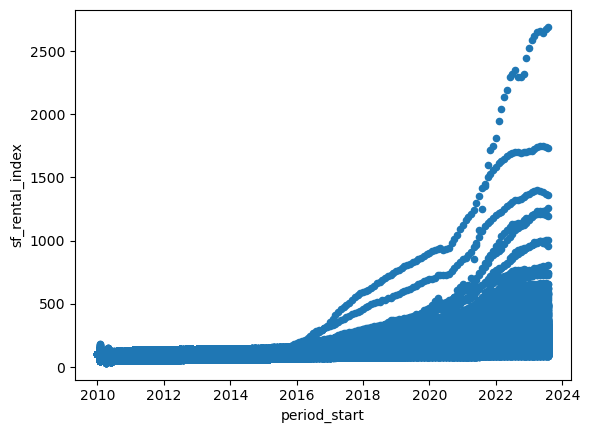

In [16]:
sfr.plot.scatter('period_start','sf_rental_index')

In [ ]:
# Read in migration and geo data

In [36]:
migration_ga = pd.read_csv('../data/area_migration_ga_zip.csv', index_col = 0)
migration_ga.head()

,area,us_state_id,us_state,us_zip_id,us_zip,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
location_id,,,,,,,,,,,,,,,,,,,,,,,
31018,238943649,13,Georgia,31018,31018,2023-06-01,2023-06-30,0.0262,3005,0,0,0,0,0,0,-29,0.0000,34611,0.0000,0.0000,38.7,0.0000,1
30011,69386929,13,Georgia,30011,30011,2023-06-01,2023-06-30,0.0395,16943,52,157,105,49,147,98,1673,69231.7891,73195,-3963.2146,31.4163,33.6,-2.1837,1
39859,153473124,13,Georgia,39859,39859,2023-06-01,2023-06-30,0.0170,1325,0,0,0,0,0,0,13,0.0000,31944,0.0000,0.0000,40.1,0.0000,1
30165,440778795,13,Georgia,30165,30165,2023-06-01,2023-06-30,0.0414,41854,-25,127,152,-23,119,142,-2255,45105.1797,55448,-10342.8203,32.5354,37.2,-4.6646,1
31798,205162809,13,Georgia,31798,31798,2023-06-01,2023-06-30,0.0157,1091,0,0,0,0,0,0,-11,0.0000,46111,0.0000,0.0000,34.0,0.0000,1


In [37]:
migration_ga['observation_start_date'] = pd.to_datetime(migration_ga['observation_start_date'],
                                                         format = '%Y-%m-%d')

In [5]:
cbsa = pd.read_csv('../data/census_cbsa_zip_tract.csv', index_col = 0)
cbsa.head(20)
# lat and lon for cbsa, zcta, tracts

,census_cbsa_geoid,census_cbsa_name,census_cbsa_lsad,census_cbsa_lat,census_cbsa_lon,census_zcta5_geoid,census_zcta5_lat,census_zcta5_lon,census_tract_geoid,census_tract_lat,census_tract_lon
0,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149953800,41.245562,-86.539415
1,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149953900,41.223357,-86.626671
2,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149954000,41.288932,-86.621202
3,NaN,NaN,NaN,NaN,NaN,46534,41.285345,-86.617818,18149953700,41.349693,-86.591977
4,21780.0,"Evansville, IN-KY",M1,38.020070,-87.586166,47660,38.296067,-87.328127,18051050300,38.280515,-87.379887
5,27540.0,"Jasper, IN",M2,38.384156,-87.035954,47660,38.296067,-87.328127,18051050300,38.280515,-87.379887
6,14020.0,"Bloomington, IN",M1,39.241736,-86.671754,47424,39.020048,-86.882428,18055955400,39.031930,-86.932400
7,14020.0,"Bloomington, IN",M1,39.241736,-86.671754,47424,39.020048,-86.882428,18055954800,39.110252,-86.922536
8,14020.0,"Bloomington, IN",M1,39.241736,-86.671754,47424,39.020048,-86.882428,18055954701,38.973253,-86.763794
9,47780.0,"Washington, IN",M2,38.696090,-87.076943,47519,38.590053,-86.983857,18027954502,38.602712,-86.992695


In [ ]:
# Multifamily data

In [6]:
mf_occ = pd.read_csv('../data/haystacks_occfile_7-26-2023.csv', index_col = None)
mf_occ.head()

,PID,Period,Occupancy
0,96_872,01/01/2015,97.9
1,96_872,02/01/2015,97.9
2,96_872,03/01/2015,97.7
3,96_872,04/01/2015,97.7
4,96_872,05/01/2015,97.7


In [34]:
len(mf_occ['PID'].unique()) # 62950 PID

62950

In [17]:
mf_occ['Period'] = pd.to_datetime(mf_occ['Period'], format='%m/%d/%Y')
mf_occ['Period'].unique() # 2015 to 2023

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01

In [7]:
mf_rent = pd.read_csv('../data/haystacks_rent_7-17-2023.csv', index_col = None)
mf_rent.head()

,PID,UnitType,Period,Rent
0,1_1004,1BR,2015-01-01,473.0
1,1_1004,1BR,2015-02-01,475.0
2,1_1004,1BR,2015-03-01,474.0
3,1_1004,1BR,2015-04-01,473.0
4,1_1004,1BR,2015-05-01,472.0


In [37]:
len(mf_rent['PID'].unique()) #64739

64739

In [50]:
mf_rent['Period'] = pd.to_datetime(mf_rent['Period'], format='%Y-%m-%d')
mf_rent['Period'].unique() # 2015 to 2023

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01

In [51]:
mfr = pd.merge(mf_occ, mf_rent, on = ['PID', 'Period'])
mfr.head(20)
# each PID listed with multiple unit types 
# different rent collected for different units
# occupancy rate is for the whole property

,PID,Period,Occupancy,UnitType,Rent
0,96_872,2015-01-01,97.9,1BR,741.727941
1,96_872,2015-01-01,97.9,2BR/1Bath,861.650000
2,96_872,2015-01-01,97.9,2BR/2Bath,942.677419
3,96_872,2015-02-01,97.9,1BR,752.205882
4,96_872,2015-02-01,97.9,2BR/1Bath,873.250000
5,96_872,2015-02-01,97.9,2BR/2Bath,966.451613
6,96_872,2015-03-01,97.7,1BR,754.970588
7,96_872,2015-03-01,97.7,2BR/1Bath,877.100000
8,96_872,2015-03-01,97.7,2BR/2Bath,957.774194
9,96_872,2015-04-01,97.7,1BR,757.735294


In [17]:
mfr['UnitType'].unique()

array(['1BR', '2BR/1Bath', '2BR/2Bath', '3BR+', 'Studio'], dtype=object)

In [20]:
prop = pd.read_csv('../data/PropertyFileAugust2023.csv', index_col = None)
prop.head()

,Market,Submarket,PID,propertyname,addressall,city,state,zipcode,Longitude,Latitude,nounits,completedyear,propertyquality,locationquality,website,ControlledAccess,FitnessCenter,businesscenter,clubhouse,coveredparking,TotalParkingSpaces,parkingtype,RentOffice,mediaroom,minstories,maxstories,ElevatorServed,wdhookup,wdinunit,SiteSizeAcres,NumberBuildings,county,ParcelComplete,mixeduse,OccupancyDate,Occupancy
0,Albany,1 - Central Albany,151_1100730,Abraxas at 90 State,90 State Street,Albany,NY,12207,-73.753301,42.649623,162,2024.0,NaN,B-,https://www.abraxasat90state.com,Yes,Yes,Yes,Yes,NaN,0.0,None,StandAlone,Y,15.0,15.0,Yes,None,All,0.38,1.0,Albany,010100-076-042-0001-005-000-0000,NaN,NaN,NaN
1,Albany,1 - Central Albany,151_1154,20 Park Residences,20 Park Street,Albany,NY,12207,-73.756933,42.650379,73,2016.0,B+,B-,NaN,Yes,Yes,No,Yes,NaN,28.0,Grade Level,StandAlone,N,5.0,5.0,Yes,None,All,0.44,1.0,Albany,76.33-1-12,No,2023-07-01,0.958904
2,Albany,1 - Central Albany,151_1171488,3rd Avenue & Elizabeth Street,3rd Avenue & Elizabeth Street,Albany,NY,12202,-73.761864,42.639730,100,NaN,NaN,C-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Albany,NaN,NaN,NaN,NaN
3,Albany,1 - Central Albany,151_1179,"Gallery on Holland, The",25 Holland Avenue,Albany,NY,12209,-73.771652,42.646851,60,NaN,NaN,B-,NaN,NaN,Yes,NaN,Yes,NaN,59.0,Multi-Level Structure,NaN,NaN,4.0,4.0,Yes,NaN,NaN,1.10,1.0,Albany,010100-076-047-0001-025-000-0000,NaN,NaN,NaN
4,Albany,1 - Central Albany,151_131,State Street Tower,397 State Street,Albany,NY,12210,-73.765924,42.657046,60,1925.0,C,C+,http://www.statestreettower.com/index.html,Yes,Yes,No,No,NaN,0.0,None,StandAlone,N,3.0,13.0,Yes,None,None,0.18,2.0,Albany,"65.80-3-49.1, 65.80-3-49.2",No,2023-07-01,0.933333


In [228]:
prop['Market'].unique()

array(['Albany', 'Albuquerque', 'Allentown-Bethlehem', 'Amarillo',
       'Anchorage', 'Asheville', 'Athens', 'Atlanta - Suburban',
       'Atlanta - Urban', 'Augusta', 'Austin', 'Baltimore', 'Baton Rouge',
       'Bay Area - East Bay', 'Bay Area - South Bay',
       'Binghamton University', 'Birmingham', 'Boise', 'Boston',
       'Bridgeport - New Haven', 'Brooklyn', 'Buffalo', 'Central Coast',
       'Central East Texas', 'Central Michigan University',
       'Central Valley', 'Charleston', 'Charlotte', 'Chattanooga',
       'Chicago - Suburban', 'Chicago - Urban', 'Cincinnati',
       'Clarksville', 'Cleveland - Akron', 'Colorado Springs', 'Columbia',
       'Columbus', 'Columbus GA', 'Cornell University', 'Corpus Christi',
       'Dallas - North', 'Dallas - Suburban', 'Dayton', 'Denver',
       'Des Moines', 'Detroit', 'East Tennessee State University',
       'El Paso', 'Eugene', 'Fayetteville NC', 'Fort Lauderdale',
       'Fort Wayne', 'Fort Worth', 'Grand Rapids', 'Greenville',

In [52]:
atl_urb_prop = prop[prop['Market'] == 'Atlanta - Urban']
len(atl_urb_prop['PID'].unique()) # 1262 properties

1262

In [53]:
atl_urb_mfr = pd.merge(mfr, atl_urb_prop, on = 'PID')
atl_urb_mfr = atl_urb_mfr[['PID', 'Period', 'Occupancy_x', 'UnitType', 'Rent', 'nounits', 'zipcode']]
atl_urb_mfr.head(20)

,PID,Period,Occupancy_x,UnitType,Rent,nounits,zipcode
0,22_53,2015-01-01,95.3,1BR,514.0,148,30274
1,22_53,2015-01-01,95.3,2BR/1Bath,535.0,148,30274
2,22_53,2015-02-01,95.3,1BR,519.0,148,30274
3,22_53,2015-02-01,95.3,2BR/1Bath,539.0,148,30274
4,22_53,2015-03-01,95.3,1BR,524.0,148,30274
5,22_53,2015-03-01,95.3,2BR/1Bath,551.0,148,30274
6,22_53,2015-04-01,94.6,1BR,529.0,148,30274
7,22_53,2015-04-01,94.6,2BR/1Bath,563.0,148,30274
8,22_53,2015-05-01,95.3,1BR,534.0,148,30274
9,22_53,2015-05-01,95.3,2BR/1Bath,575.0,148,30274


In [36]:
atl_urb_mfr.isna().sum()

PID               0
Period            0
Occupancy_x       0
UnitType          0
Rent           5574
zipcode           0
dtype: int64

In [54]:
atl_urb_mfr = atl_urb_mfr.dropna()

In [42]:
len(atl_urb_mfr['PID'].unique()) # 844 properties

844

<Axes: >

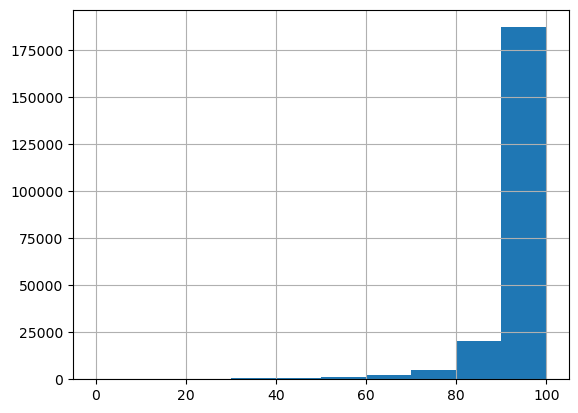

In [44]:
atl_urb_mfr['Occupancy_x'].hist()

In [46]:
# '1BR', '2BR/1Bath', '2BR/2Bath', '3BR+', 'Studio'
atl_urb_mfr['UnitType'].value_counts()

1BR          68917
2BR/2Bath    65598
3BR+         41640
2BR/1Bath    28089
Studio       13001
Name: UnitType, dtype: int64

In [55]:
atl_unit_mean = atl_urb_mfr.groupby(['UnitType', 'Period'])['Rent'].agg(['mean']).reset_index()
atl_unit_mean.pivot(index = 'Period', columns = 'UnitType', values = 'mean')

UnitType,1BR,2BR/1Bath,2BR/2Bath,3BR+,Studio
Period,,,,,
2015-01-01,901.611655,922.826727,1161.674958,1351.173390,919.034275
2015-02-01,908.602998,926.713252,1167.040531,1355.201852,926.319846
2015-03-01,912.756379,932.214398,1177.392197,1362.410260,937.758273
2015-04-01,919.323964,943.168740,1187.696930,1370.949565,944.405547
2015-05-01,920.758643,945.068570,1199.470710,1379.892787,949.296845
2015-06-01,931.104918,961.802086,1213.723425,1396.248230,963.170153
2015-07-01,936.781424,969.205030,1221.229649,1403.658490,959.950686
2015-08-01,944.215690,972.686614,1229.913092,1406.195293,974.073895
2015-09-01,946.717915,975.419749,1229.516633,1398.225053,970.957008


<Axes: xlabel='Period'>

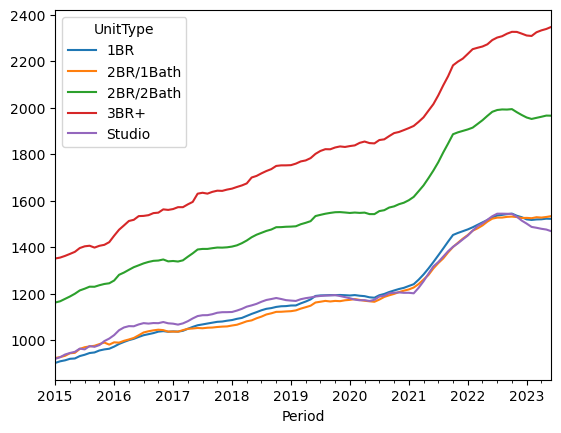

In [48]:
atl_unit_mean.pivot(index = 'Period', columns = 'UnitType', values = 'mean').plot()

In [56]:
atl_zip_mean = atl_urb_mfr.groupby(['zipcode', 'Period'])['Rent'].agg(['mean']).reset_index()
atl_zip_mean = atl_zip_mean.rename({'mean': 'mean_rent_mf', 'Period':'period_start'}, axis = 1)
atl_zip_mean

,zipcode,period_start,mean_rent_mf
0,30002,2015-01-01,630.703297
1,30002,2015-02-01,651.760989
2,30002,2015-03-01,632.815934
3,30002,2015-04-01,640.076923
4,30002,2015-05-01,629.846154
...,...,...,...
5541,30363,2023-02-01,2625.106881
5542,30363,2023-03-01,2622.521827
5543,30363,2023-04-01,2619.936774
5544,30363,2023-05-01,2617.351720


<Axes: xlabel='period_start'>

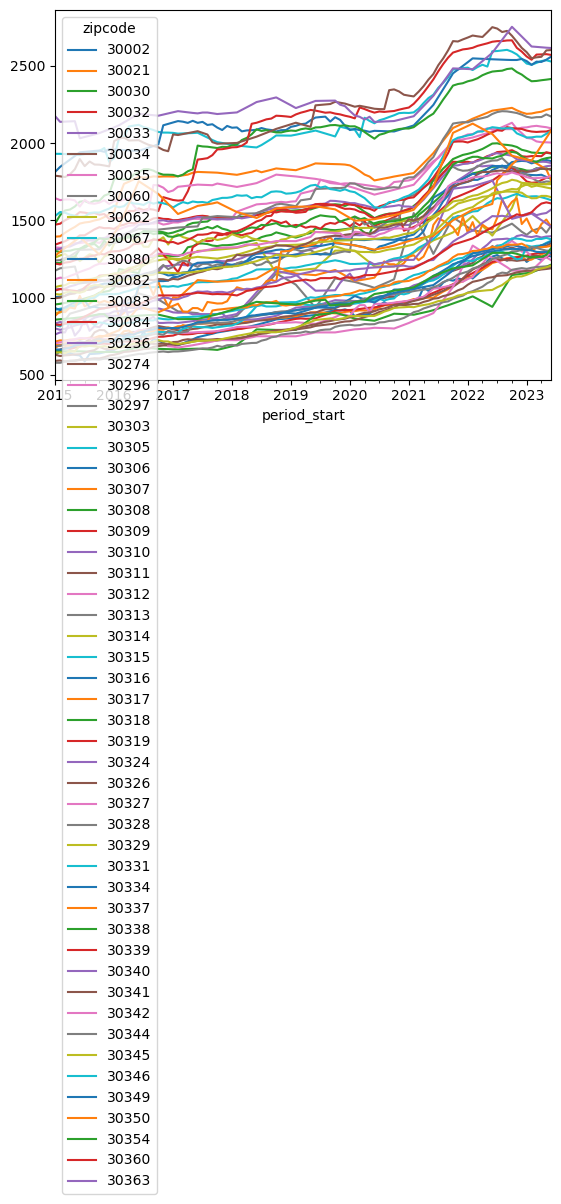

In [52]:
atl_zip_mean.pivot(index = 'period_start', columns = 'zipcode', values = 'mean_rent_mf').plot()

In [86]:
sfr.head()

,period_start,sf_rental_index,zipcode,trans_period,coef,sf_price_index
0,2010-02-01,100.000000,47038,38.0,-0.228594,82.953446
1,2010-03-01,67.975154,47038,39.0,-0.195522,82.872184
2,2010-04-01,78.247524,47038,40.0,-0.185380,82.536945
3,2010-05-01,62.539852,47038,41.0,-0.177184,82.263764
4,2010-06-01,50.101684,47038,42.0,-0.182479,81.827389


In [72]:
sfr.dtypes

period_start       datetime64[ns]
sf_rental_index           float64
zipcode                    object
trans_period              float64
coef                      float64
sf_price_index            float64
dtype: object

In [87]:
atl_zip_mean.dtypes

zipcode                 object
period_start    datetime64[ns]
mean_rent_mf           float64
dtype: object

In [90]:
sfr['zipcode'] = sfr['zipcode'].astype('string')
atl_zip_mean['zipcode'] = atl_zip_mean['zipcode'].astype('string')

In [91]:
atl_urb_df = pd.merge(atl_zip_mean, sfr, 
                  how = 'left',
                  on = ['zipcode', 'period_start'])
atl_urb_df

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
0,30002,2015-01-01,630.703297,114.715608,97.0,-0.224999,82.331231
1,30002,2015-02-01,651.760989,115.155485,98.0,-0.207499,82.202391
2,30002,2015-03-01,632.815934,115.694032,99.0,-0.180874,82.423472
3,30002,2015-04-01,640.076923,116.181280,100.0,-0.145673,83.115012
4,30002,2015-05-01,629.846154,117.000157,101.0,-0.126192,84.135504
...,...,...,...,...,...,...,...
5541,30363,2023-02-01,2625.106881,321.929191,194.0,0.471078,159.063094
5542,30363,2023-03-01,2622.521827,323.787196,195.0,0.489442,159.665698
5543,30363,2023-04-01,2619.936774,324.655463,196.0,0.505767,160.315226
5544,30363,2023-05-01,2617.351720,326.057108,197.0,0.509293,162.074694


In [92]:
atl_urb_zip = list(atl_zip_mean['zipcode'].unique())
atl_urb_zip

['30002',
 '30021',
 '30030',
 '30032',
 '30033',
 '30034',
 '30035',
 '30060',
 '30062',
 '30067',
 '30080',
 '30082',
 '30083',
 '30084',
 '30236',
 '30274',
 '30296',
 '30297',
 '30303',
 '30305',
 '30306',
 '30307',
 '30308',
 '30309',
 '30310',
 '30311',
 '30312',
 '30313',
 '30314',
 '30315',
 '30316',
 '30317',
 '30318',
 '30319',
 '30324',
 '30326',
 '30327',
 '30328',
 '30329',
 '30331',
 '30334',
 '30337',
 '30338',
 '30339',
 '30340',
 '30341',
 '30342',
 '30344',
 '30345',
 '30346',
 '30349',
 '30350',
 '30354',
 '30360',
 '30363']

In [ ]:
# Migration EDA

In [38]:
migration_ga.head()

,area,us_state_id,us_state,us_zip_id,us_zip,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
location_id,,,,,,,,,,,,,,,,,,,,,,,
31018,238943649,13,Georgia,31018,31018,2023-06-01,2023-06-30,0.0262,3005,0,0,0,0,0,0,-29,0.0000,34611,0.0000,0.0000,38.7,0.0000,1
30011,69386929,13,Georgia,30011,30011,2023-06-01,2023-06-30,0.0395,16943,52,157,105,49,147,98,1673,69231.7891,73195,-3963.2146,31.4163,33.6,-2.1837,1
39859,153473124,13,Georgia,39859,39859,2023-06-01,2023-06-30,0.0170,1325,0,0,0,0,0,0,13,0.0000,31944,0.0000,0.0000,40.1,0.0000,1
30165,440778795,13,Georgia,30165,30165,2023-06-01,2023-06-30,0.0414,41854,-25,127,152,-23,119,142,-2255,45105.1797,55448,-10342.8203,32.5354,37.2,-4.6646,1
31798,205162809,13,Georgia,31798,31798,2023-06-01,2023-06-30,0.0157,1091,0,0,0,0,0,0,-11,0.0000,46111,0.0000,0.0000,34.0,0.0000,1


In [94]:
migration_ga['us_zip'] = migration_ga['us_zip'].astype('string')

In [95]:
migration_atl = migration_ga[migration_ga['us_zip'].isin(atl_urb_zip)]

In [96]:
migration_atl.head()

,area,us_state_id,us_state,us_zip_id,us_zip,observation_start_date,observation_end_date,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
location_id,,,,,,,,,,,,,,,,,,,,,,,
30327,44199823,13,Georgia,30327,30327,2023-06-01,2023-06-30,0.0301,23166,-15,158,173,-14,147,161,489,67632.3594,162412,-94779.6406,31.0382,46.6,-15.5618,1
30062,67611749,13,Georgia,30062,30062,2023-06-01,2023-06-30,0.0415,63695,-10,326,336,-9,304,314,944,73176.3594,115953,-42776.6406,32.3359,41.5,-9.1641,1
30311,32347030,13,Georgia,30311,30311,2023-06-01,2023-06-30,0.0148,32214,-7,119,126,-7,111,118,-1793,45465.1797,40742,4723.1787,29.0730,38.9,-9.8270,1
30360,15579548,13,Georgia,30360,30360,2023-06-01,2023-06-30,0.0296,15587,-23,69,92,-21,64,86,-606,56997.0000,81204,-24207.0000,27.8416,34.4,-6.5584,1
30297,28627400,13,Georgia,30297,30297,2023-06-01,2023-06-30,0.0357,27158,-90,75,165,-84,70,154,-3142,46543.2695,38506,8037.2695,28.9543,30.2,-1.2457,1


In [97]:
atl_urb_df.head()

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
0,30002,2015-01-01,630.703297,114.715608,97.0,-0.224999,82.331231
1,30002,2015-02-01,651.760989,115.155485,98.0,-0.207499,82.202391
2,30002,2015-03-01,632.815934,115.694032,99.0,-0.180874,82.423472
3,30002,2015-04-01,640.076923,116.181280,100.0,-0.145673,83.115012
4,30002,2015-05-01,629.846154,117.000157,101.0,-0.126192,84.135504


In [150]:
atl_df = pd.merge(atl_urb_df, migration_atl, 
                        left_on = ['zipcode', 'period_start'],
                        right_on = ['us_zip', 'observation_start_date'])
atl_df.drop(['area', 'us_state_id', 'us_state', 'us_zip_id', 'us_zip', 
                   'observation_start_date', 'observation_end_date'], axis=1, inplace = True)
atl_df.head()

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
0,30002,2018-12-01,864.321429,139.455839,144.0,0.112014,112.494762,0.0672,6560,-29,45,74,-26,41,67,0,55394.9414,79091,-23696.0605,28.6220,41.2,-12.5780,1
1,30002,2019-01-01,866.969780,140.034157,145.0,0.108432,112.353442,0.0672,6560,-26,65,91,-23,59,82,-26,49752.9492,79091,-29338.0508,31.8260,41.2,-9.3740,1
2,30002,2019-02-01,870.157967,140.591074,146.0,0.136117,112.587389,0.0672,6560,-25,68,93,-25,68,93,-51,57344.6914,79091,-21746.3105,30.1530,41.2,-11.0470,1
3,30002,2019-03-01,878.043956,141.285830,147.0,0.154795,113.908682,0.0672,6560,-22,69,91,-20,62,82,-73,58885.5313,79091,-20205.4707,29.9247,41.2,-11.2753,1
4,30002,2019-04-01,881.304945,142.134718,148.0,0.146306,114.133338,0.0672,6560,-37,76,113,-35,71,105,-110,39910.2266,79091,-39180.7734,26.5080,41.2,-14.6920,1


In [111]:
atl_df.describe()

,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
count,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.000000,2970.0
mean,1498.393677,168.776959,171.000000,0.313934,135.717408,0.082913,31409.444444,-24.399663,331.577104,355.976768,-22.466330,305.043771,327.505051,-630.528283,60510.969663,73290.759259,-12779.789583,31.132997,34.785185,-3.652188,1.0
std,448.414475,26.772236,15.877181,0.137320,18.518720,0.108540,15980.317249,48.721273,184.219619,193.785334,44.805816,168.786709,177.505213,1080.163128,9405.173613,28468.261286,23334.273234,1.968882,4.560755,4.230580,0.0
min,750.000000,133.278411,144.000000,0.012956,100.159302,0.014800,4411.000000,-376.000000,25.000000,24.000000,-351.000000,24.000000,22.000000,-7164.000000,35026.269500,27813.000000,-103220.242200,20.954100,21.700000,-18.375300,1.0
25%,1153.596327,147.501083,157.000000,0.192623,119.785946,0.036100,23166.000000,-50.000000,196.000000,215.000000,-46.000000,180.000000,198.000000,-1016.750000,52111.233425,49135.000000,-26461.888200,30.202500,32.800000,-6.081675,1.0
50%,1435.253936,162.215122,171.000000,0.295659,131.490101,0.050200,28677.000000,-19.500000,302.000000,327.000000,-18.000000,278.000000,303.000000,-330.000000,59851.664050,69905.000000,-7077.050750,31.305700,34.650000,-3.511400,1.0
75%,1792.544500,184.487448,185.000000,0.451964,154.708630,0.075000,38396.000000,6.000000,442.000000,467.000000,5.000000,406.000000,428.000000,10.750000,68285.367150,94124.000000,4099.506100,32.179775,37.500000,-0.990600,1.0
max,2752.547344,326.057108,198.000000,0.573432,172.371294,0.567600,78801.000000,142.000000,1115.000000,1255.000000,128.000000,1041.000000,1171.000000,1231.000000,91807.250000,162412.000000,43799.425800,39.649200,46.600000,11.092900,1.0


In [ ]:
# time series visualization

<Axes: xlabel='period_start'>

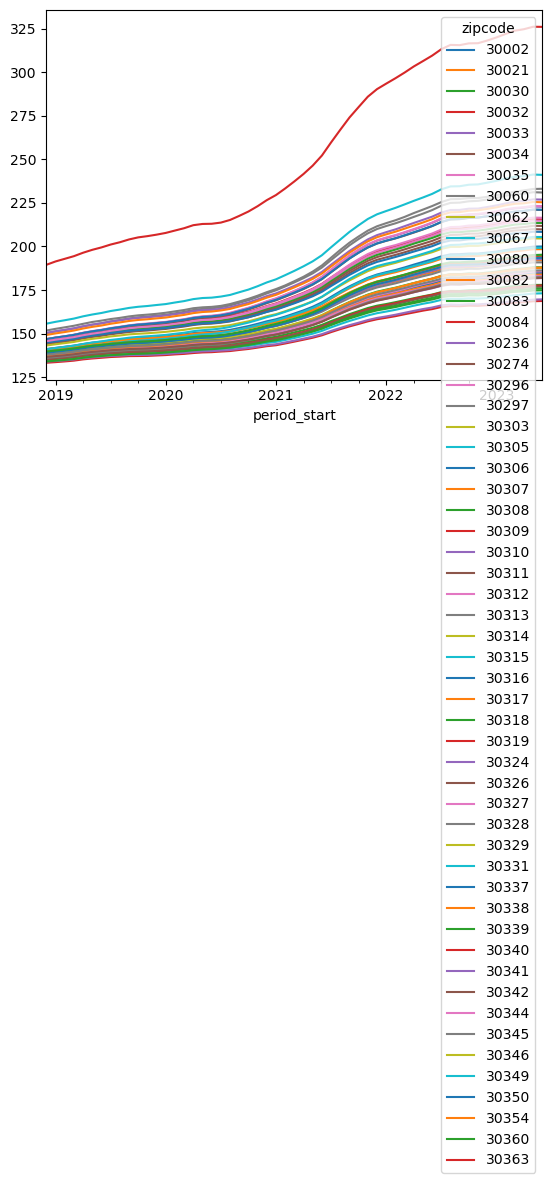

In [151]:
sfr_zip = atl_df.pivot(index = 'period_start', columns = 'zipcode', values = 'sf_rental_index')
sfr_zip.plot()

In [152]:
sfr_zip.head()

zipcode,30002,30021,30030,30032,30033,30034,30035,30060,30062,30067,30080,30082,30083,30084,30236,30274,30296,30297,30303,30305,30306,30307,30308,30309,30310,30311,30312,30313,30314,30315,30316,30317,30318,30319,30324,30326,30327,30328,30329,30331,30337,30338,30339,30340,30341,30342,30344,30345,30346,30349,30350,30354,30360,30363
period_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-01,139.455839,139.037721,135.832213,146.847148,136.670652,144.001650,145.419068,151.763792,138.604880,139.250464,141.156506,140.210551,145.277849,139.071679,146.620022,146.129314,146.831612,150.250404,140.828929,134.279170,138.501002,138.129270,135.011996,133.278411,150.428310,144.461364,137.196878,139.463812,143.165944,155.694532,144.874285,141.005995,137.761716,135.337088,133.911429,135.406332,137.632051,136.100085,139.049456,139.349601,146.809105,137.573706,134.035978,139.623021,139.612438,136.641527,145.645901,137.923303,139.574863,140.959427,139.040887,149.196339,139.704197,189.467250
2019-01-01,140.034157,139.618470,136.259427,147.648638,137.149819,144.751643,146.226614,152.727395,139.160528,139.809336,141.803426,140.856200,146.073232,139.654012,147.530466,147.022847,147.755417,151.227704,141.430426,134.662494,138.998303,138.606741,135.411491,133.630456,151.365583,145.261627,137.676502,140.031592,143.884029,156.749839,145.580294,141.586092,138.315131,135.756330,134.264441,135.823155,138.128210,136.553501,139.576774,140.035350,147.708985,138.080462,134.446423,140.199928,140.174303,137.094374,146.497889,138.432034,140.138043,141.724655,139.604471,150.109749,140.290400,191.391952
2019-02-01,140.591074,140.145521,136.744751,148.379358,137.622965,145.421324,146.913260,153.593253,139.747107,140.398803,142.438230,141.474841,146.734417,140.162800,148.261662,147.750619,148.502350,152.029745,142.031177,135.083377,139.532092,139.155789,135.884548,134.029383,152.161621,145.946400,138.197783,140.601464,144.533308,157.656918,146.262369,142.195887,138.853125,136.178886,134.656628,136.250058,138.629011,137.036351,140.082320,140.640728,148.451122,138.580592,134.901977,140.718681,140.693903,137.551221,147.214445,138.911542,140.677607,142.366279,140.150937,150.888734,140.827236,192.903184
2019-03-01,141.285830,140.821749,137.344010,149.249954,138.227143,146.259069,147.770837,154.495508,140.399853,141.054186,143.113913,142.133980,147.554780,140.828026,149.147573,148.601288,149.353387,152.949602,142.667766,135.588623,140.128086,139.767351,136.396434,134.490125,152.995794,146.663001,138.767330,141.208491,145.216972,158.619195,147.036211,142.894099,139.430223,136.739596,135.141758,136.793817,139.224941,137.621498,140.710036,141.263276,149.265677,139.201288,135.420436,141.378436,141.350794,138.135348,147.975156,139.535229,141.338964,143.056149,140.807784,151.755340,141.491186,194.421476
2019-04-01,142.134718,141.645515,138.103331,150.296461,138.991641,147.255511,148.776715,155.603594,141.193551,141.870192,143.997411,143.007240,148.528787,141.639216,150.287357,149.726834,150.492483,154.150118,143.591659,136.322083,140.965317,140.595760,137.171058,135.218746,154.165475,147.692749,139.597902,142.098240,146.200063,159.908805,148.061890,143.803850,140.276866,137.472331,135.865647,137.540391,140.022903,138.357467,141.544201,142.177368,150.380032,139.960131,136.131653,142.194105,142.173058,138.898836,149.054802,140.324877,142.156411,144.028275,141.597897,152.922069,142.303160,196.399801


In [ ]:
# Seasonal decomposition

In [169]:
atl_df.index = pd.DatetimeIndex(atl_df['period_start'])

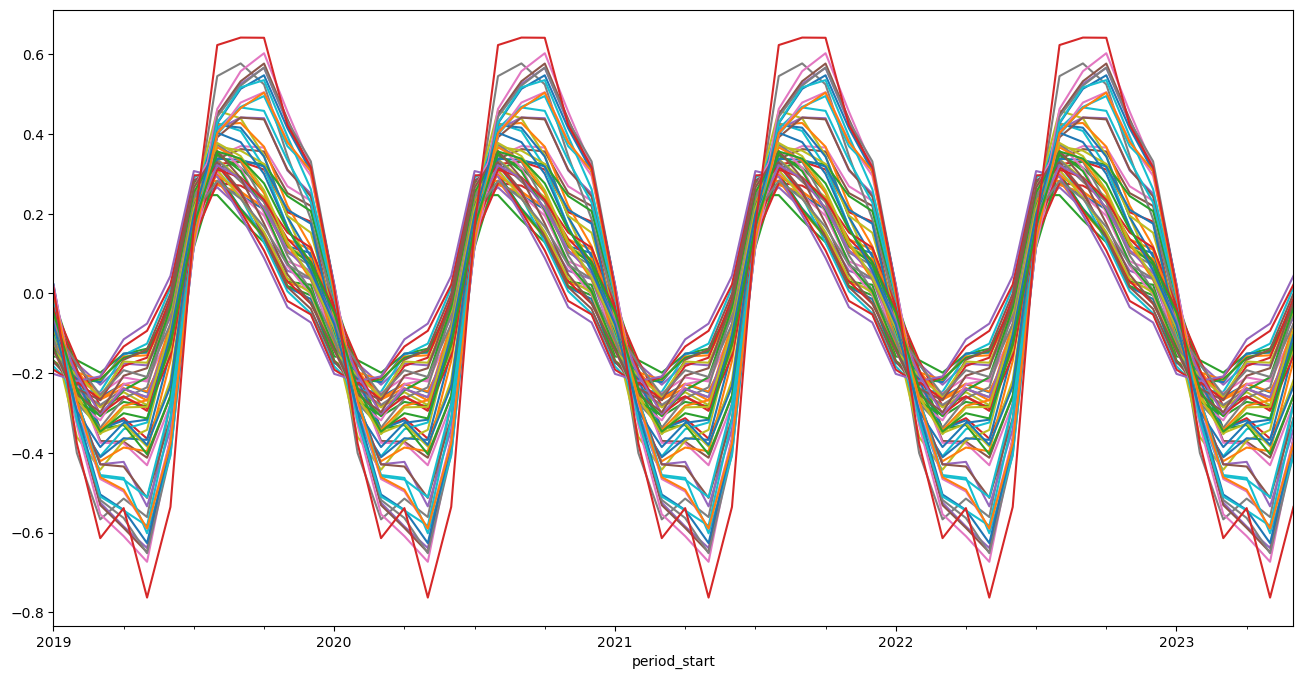

In [168]:
fig, ax = plt.subplots(figsize=(16,8))

# Create a dictionary to store decomposition results for each zipcode
decomposition_results = {}

for zipcode in atl_df['zipcode'].unique():
    # Filter the DataFrame for the current zipcode
    zipcode_df = atl_df[atl_df['zipcode'] == zipcode]
    
    # Perform time series decomposition
    decomposition = seasonal_decompose(zipcode_df['sf_rental_index'], model='additive')
    
    # Store the decomposition results in the dictionary
    decomposition_results[zipcode] = decomposition
    
    # Plot it
    decomposition.seasonal['2019':"2023"].plot();

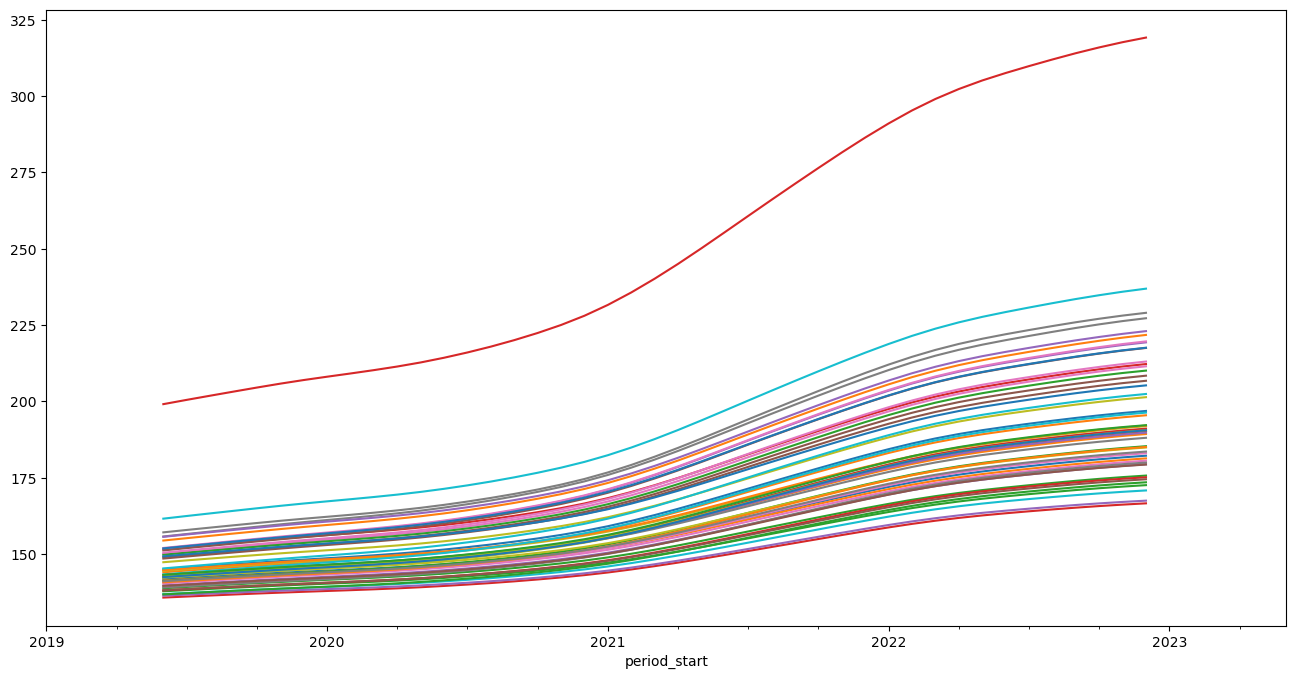

In [170]:
fig, ax = plt.subplots(figsize=(16,8))

# Create a dictionary to store decomposition results for each zipcode
decomposition_results = {}

for zipcode in atl_df['zipcode'].unique():
    # Filter the DataFrame for the current zipcode
    zipcode_df = atl_df[atl_df['zipcode'] == zipcode]
    
    # Perform time series decomposition
    decomposition = seasonal_decompose(zipcode_df['sf_rental_index'], model='additive')
    
    # Store the decomposition results in the dictionary
    decomposition_results[zipcode] = decomposition
    
    # Plot it
    decomposition.trend['2019':"2023"].plot();

In [172]:
# correlation plot from Ellie

seasonality_dict = {
    ts: seasonal_decompose(atl_df[ts].seasonal for ts in atl_df.columns)
}

# Compute corr matrix
seasonality_corr = pd.DataFrame(seasonality_dict).corr()

sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show();

NameError: name 'ts' is not defined

In [144]:
sfr_zip_samp = sfr_zip[['30363']]

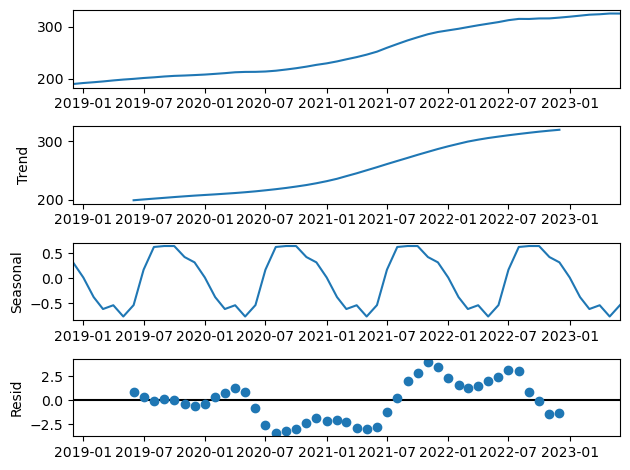

In [163]:
result = seasonal_decompose(sfr_zip_samp)
result.plot()
plt.show()

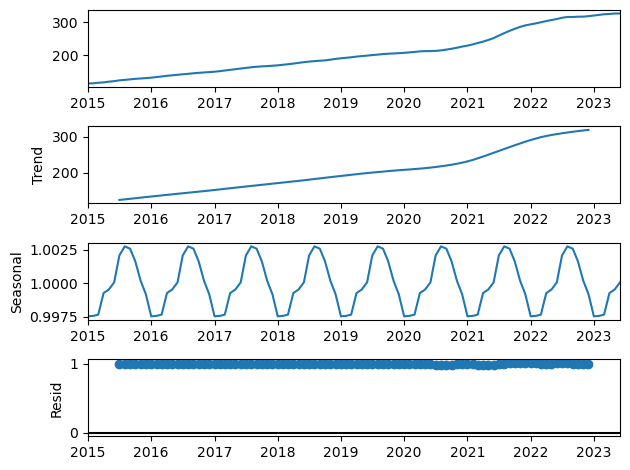

In [102]:
result = seasonal_decompose(sfr_zip_samp, model = 'multiplicative')
result.plot()
plt.show()

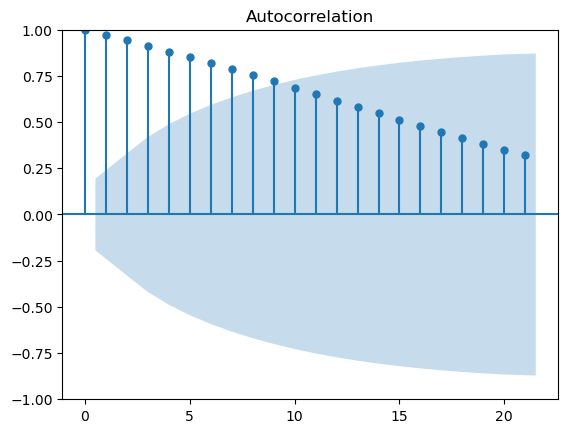

In [225]:
plot_acf(sfr_zip_samp)
plt.show()
# high autocorrelation for distance observations
# suggesting smooth time series and high linear dependence between observations

/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


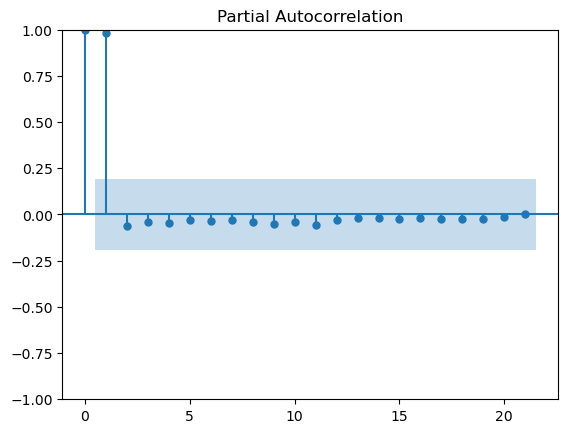

In [226]:
plot_pacf(sfr_zip_samp)
plt.show()
# significant information added in lags 1-2

In [104]:
atl_urb_df.head()

,zipcode,period_start,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
0,30002,2015-01-01,630.703297,114.715608,97.0,-0.224999,82.331231
1,30002,2015-02-01,651.760989,115.155485,98.0,-0.207499,82.202391
2,30002,2015-03-01,632.815934,115.694032,99.0,-0.180874,82.423472
3,30002,2015-04-01,640.076923,116.181280,100.0,-0.145673,83.115012
4,30002,2015-05-01,629.846154,117.000157,101.0,-0.126192,84.135504


In [123]:
atl_urb_df.corr()
# low correlation between mfr and sfr when looking at aggregate - why?

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_79177/613357534.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  atl_urb_df.corr()


,mean_rent_mf,sf_rental_index,trans_period,coef,sf_price_index
mean_rent_mf,1.000000,0.321990,0.428309,0.534657,0.533641
sf_rental_index,0.321990,1.000000,0.868847,0.855357,0.865065
trans_period,0.428309,0.868847,1.000000,0.972799,0.964042
coef,0.534657,0.855357,0.972799,1.000000,0.991007
sf_price_index,0.533641,0.865065,0.964042,0.991007,1.000000


In [126]:
corr = atl_urb_df.groupby(['zipcode']).corr()
corr
# broken down by zipode, correlation tends to be high

/var/folders/br/94g31g292jj5vykvq71cy53m0000gn/T/ipykernel_79177/592507242.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corr = atl_urb_df.groupby(['zipcode']).corr()


mean_rent_mf  sf_rental_index  trans_period  \
zipcode                                                                
30002   mean_rent_mf         1.000000         0.991919      0.975126   
        sf_rental_index      0.991919         1.000000      0.968187   
        trans_period         0.975126         0.968187      1.000000   
        coef                 0.984345         0.981711      0.991276   
        sf_price_index       0.994504         0.995864      0.982549   
30021   mean_rent_mf         1.000000         0.993233      0.946339   
        sf_rental_index      0.993233         1.000000      0.966927   
        trans_period         0.946339         0.966927      1.000000   
        coef                 0.968376         0.984685      0.989725   
        sf_price_index       0.989759         0.996922      0.978458   
30030   mean_rent_mf         1.000000         0.970036      0.969369   
        sf_rental_index      0.970036         1.000000      0.969524   
        trans_period         0.969369         0.969524      1.000000   
        coef                 0.981335         0.981361      0.991923   
        sf_price_index       0.977449         0.995421      0.984582   
30032   mean_rent_mf         1.000000         0.997217      0.965217   
        sf_rental_index      0.997217         1.000000      0.969274   
        trans_period         0.965217         0.969274      1.000000   
        coef                 0.975792         0.982590      0.991318   
        sf_price_index       0.993951         0.996514      0.981889   
30033   mean_rent_mf         1.000000         0.994337      0.958234   
        sf_rental_index      0.994337         1.000000      0.967439   
        trans_period         0.958234         0.967439      1.000000   
        coef                 0.977205         0.982354      0.991136   
        sf_price_index       0.987506         0.995479      0.982547   
30034   mean_rent_mf         1.000000         0.994877      0.961701   
        sf_rental_index      0.994877         1.000000      0.968652   
        trans_period         0.961701         0.968652      1.000000   
        coef                 0.979585         0.984597      0.989419   
        sf_price_index       0.994290         0.997724      0.977085   
30035   mean_rent_mf         1.000000         0.980315      0.924595   
        sf_rental_index      0.980315         1.000000      0.968087   
        trans_period         0.924595         0.968087      1.000000   
        coef                 0.954287         0.986635      0.988290   
        sf_price_index       0.981116         0.998110      0.974202   
30060   mean_rent_mf         1.000000         0.916562      0.887568   
        sf_rental_index      0.916562         1.000000      0.968005   
        trans_period         0.887568         0.968005      1.000000   
        coef                 0.914027         0.992535      0.984330   
        sf_price_index       0.911995         0.998721      0.967112   
30062   mean_rent_mf         1.000000         0.864228      0.823761   
        sf_rental_index      0.864228         1.000000      0.964440   
        trans_period         0.823761         0.964440      1.000000   
        coef                 0.852342         0.992917      0.981500   
        sf_price_index       0.864356         0.998613      0.963314   
30067   mean_rent_mf         1.000000         0.995462      0.950615   
        sf_rental_index      0.995462         1.000000      0.965378   
        trans_period         0.950615         0.965378      1.000000   
        coef                 0.983672         0.991057      0.985138   
        sf_price_index       0.994130         0.998407      0.969408   
30080   mean_rent_mf         1.000000         0.991083      0.943197   
        sf_rental_index      0.991083         1.000000      0.966632   
        trans_period         0.943197         0.966632      1.000000   
        coef                 0.978114         0.990138      0.987

In [ ]:
# Creating MFR Occupancy Rate and Rental Index by Zipcode

In [154]:
atl_occ = pd.merge(mf_occ, atl_urb_prop, on = 'PID')
atl_occ = atl_occ[['PID', 'Period', 'Occupancy_x', 'nounits', 'zipcode']]
atl_occ

,PID,Period,Occupancy_x,nounits,zipcode
0,22_53,2015-01-01,95.3,148,30274
1,22_53,2015-02-01,95.3,148,30274
2,22_53,2015-03-01,95.3,148,30274
3,22_53,2015-04-01,94.6,148,30274
4,22_53,2015-05-01,95.3,148,30274
...,...,...,...,...,...
79634,22_1414869,2023-02-01,86.6,238,30311
79635,22_1414869,2023-03-01,84.5,238,30311
79636,22_1414869,2023-04-01,81.9,238,30311
79637,22_1414869,2023-05-01,79.8,238,30311


In [158]:
atl_occ['Occupancy_x'] = atl_occ['Occupancy_x']/100
atl_occ['occupied_units'] = atl_occ['Occupancy_x'] * atl_occ['nounits']
atl_occ = atl_occ.groupby(['zipcode', 'Period'], as_index=False)[['nounits','occupied_units']].sum()
atl_occ['occupancy_by_zip'] = atl_occ['occupied_units'] / atl_occ['nounits']
atl_occ

,zipcode,Period,nounits,occupied_units,occupancy_by_zip
0,30002,2015-01-01,592,538.940,0.910372
1,30002,2015-02-01,592,538.940,0.910372
2,30002,2015-03-01,592,540.248,0.912581
3,30002,2015-04-01,592,537.196,0.907426
4,30002,2015-05-01,592,537.196,0.907426
...,...,...,...,...,...
5541,30363,2023-02-01,1541,1333.632,0.865433
5542,30363,2023-03-01,1541,1327.538,0.861478
5543,30363,2023-04-01,1541,1322.808,0.858409
5544,30363,2023-05-01,1541,1318.465,0.855591


In [180]:
atl_rent = pd.merge(mf_rent, atl_urb_prop, on = 'PID')
atl_rent = atl_rent[['PID', 'Period', 'UnitType', 'Rent', 'nounits', 'zipcode']]
atl_rent

,PID,Period,UnitType,Rent,nounits,zipcode
0,22_1004844,2015-01-01,1BR,1080.774194,366,30338
1,22_1004844,2015-02-01,1BR,1138.064516,366,30338
2,22_1004844,2015-03-01,1BR,1127.903226,366,30338
3,22_1004844,2015-04-01,1BR,1117.741935,366,30338
4,22_1004844,2015-05-01,1BR,1107.580645,366,30338
...,...,...,...,...,...,...
246272,22_9894,2023-02-01,Studio,1319.000000,339,30339
246273,22_9894,2023-03-01,Studio,1324.000000,339,30339
246274,22_9894,2023-04-01,Studio,1324.000000,339,30339
246275,22_9894,2023-05-01,Studio,1324.000000,339,30339


In [162]:
atl_rent['UnitType'].unique()

array(['1BR', '2BR/1Bath', '2BR/2Bath', '3BR+', 'Studio'], dtype=object)

In [181]:
tenant_dict = {'Studio': 1, '1BR': 1, '2BR/1Bath': 2, '2BR/2Bath':2, '3BR+': 3}
atl_rent['tenants'] = atl_rent['UnitType'].map(tenant_dict)
atl_rent

,PID,Period,UnitType,Rent,nounits,zipcode,tenants
0,22_1004844,2015-01-01,1BR,1080.774194,366,30338,1
1,22_1004844,2015-02-01,1BR,1138.064516,366,30338,1
2,22_1004844,2015-03-01,1BR,1127.903226,366,30338,1
3,22_1004844,2015-04-01,1BR,1117.741935,366,30338,1
4,22_1004844,2015-05-01,1BR,1107.580645,366,30338,1
...,...,...,...,...,...,...,...
246272,22_9894,2023-02-01,Studio,1319.000000,339,30339,1
246273,22_9894,2023-03-01,Studio,1324.000000,339,30339,1
246274,22_9894,2023-04-01,Studio,1324.000000,339,30339,1
246275,22_9894,2023-05-01,Studio,1324.000000,339,30339,1


In [182]:
atl_rent = atl_rent.groupby(['zipcode', 'Period'], as_index=False)[['tenants', 'Rent']].sum()
atl_rent

,zipcode,Period,tenants,Rent
0,30002,2015-01-01,14,5207.813187
1,30002,2015-02-01,14,5331.043956
2,30002,2015-03-01,14,5229.263736
3,30002,2015-04-01,14,5232.307692
4,30002,2015-05-01,14,5165.384615
...,...,...,...,...
5694,30363,2023-02-01,28,39376.603213
5695,30363,2023-03-01,28,39337.827409
5696,30363,2023-04-01,28,39299.051604
5697,30363,2023-05-01,28,39260.275800


In [184]:
atl_rent['rent_per_person'] = atl_rent['Rent'] / atl_rent['tenants']
atl_rent

,zipcode,Period,tenants,Rent,rent_per_person
0,30002,2015-01-01,14,5207.813187,371.986656
1,30002,2015-02-01,14,5331.043956,380.788854
2,30002,2015-03-01,14,5229.263736,373.518838
3,30002,2015-04-01,14,5232.307692,373.736264
4,30002,2015-05-01,14,5165.384615,368.956044
...,...,...,...,...,...
5694,30363,2023-02-01,28,39376.603213,1406.307258
5695,30363,2023-03-01,28,39337.827409,1404.922407
5696,30363,2023-04-01,28,39299.051604,1403.537557
5697,30363,2023-05-01,28,39260.275800,1402.152707


In [188]:
atl_rent.describe()

,zipcode,tenants,Rent,rent_per_person
count,5699.000000,5699.000000,5699.000000,5699.000000
mean,30250.694332,78.588173,59737.145964,726.235429
std,122.071742,62.329152,56163.238002,270.172246
min,30002.000000,2.000000,625.000000,286.351375
25%,30084.000000,27.000000,16035.772910,507.253879
50%,30313.000000,66.000000,45080.907493,679.965177
75%,30337.000000,123.000000,86365.004681,911.434931
max,30363.000000,287.000000,313340.944231,1521.079284


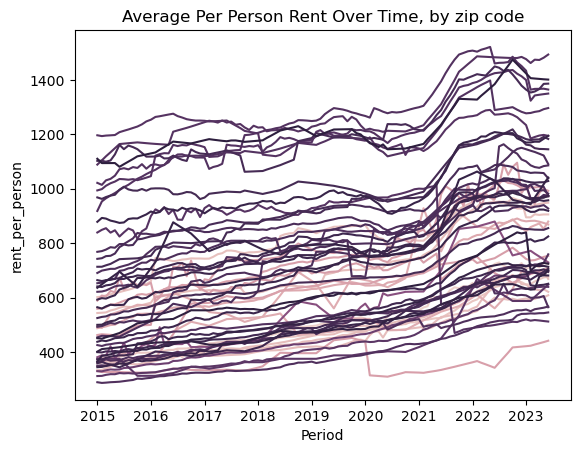

In [187]:
sns.lineplot(data=atl_rent, x='Period', y='rent_per_person', hue='zipcode', legend=False)
plt.title('Average Per Person Rent Over Time, by zip code')
plt.show()